# Q4: PG Algs Cartpole Arena :)

## DDPG (Deep Deterministic Policy Gradient)

Until now, we applied policy gradient (on-policy) in order to handle continuos spaces.

DDPG (Deep Deterministic Policy Gradient) algorithm applies policy gradient and Actor-Critic architecture in deep Q-learning discussed in DQN. But, as you can see later, it is "deterministic" (not "stochastic"), and this is then why it's called **off-policy** architecture.

In [1]:
!pip install torch numpy matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
import random
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

Because DDPG cannot operate discrete action space, and here we then use custom CartPole implementation for continuous action space.<br>
The shape of action space in this example is ```Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)```.

In [34]:
import math
import random

class CartPole():
    def __init__(self):
        self._cart_mass = 0.31  # (kg)
        self._pole_mass = 0.055  # (kg)
        self._pole_length = 0.4  # (m)

        self.x_threshold = 1.0
        self.theta_threshold = 12 * 2 * math.pi / 360

        self._state = []
        self._done = True

    def reset(self):
        self._step = 0
        self._cart_position = math.tanh(random.gauss(0.0, 0.01)) * 4.8  # (m)
        self._cart_velocity = random.uniform(-0.05, 0.05)  # (m/s)
        initial_pole_angle=random.uniform(-0.05, 0.05)
        self._pole_angle =  (initial_pole_angle + math.pi) % (2 * math.pi) - math.pi  # (rad)
        self._pole_angular_velocity = random.uniform(-0.05, 0.05)  # (rad/s)

        # (CartPole-v0 uses numpy.ndarray for state,
        #  but here returns Python array.)
        self._state = [self._cart_position, self._cart_velocity, self._pole_angle, self._pole_angular_velocity]
        self._done = False
        return self._state

    def step(self, action: float):
        """
        Args:
            action: float value between -1.0 and 1.0
        """
        if self._done:
            raise Exception("Cannot run step() before reset")

        self._step += 1

        # Add a small random noise
        # (The agent won't succeed by applying zero force each time.)
        force = 1.0 * (action + random.uniform(-0.02, 0.02))

        total_mass = self._cart_mass + self._pole_mass
        pole_half_length = self._pole_length / 2
        pole_mass_length = self._pole_mass * pole_half_length

        cosTheta = math.cos(self._pole_angle)
        sinTheta = math.sin(self._pole_angle)

        temp = (
            force + pole_mass_length * self._pole_angular_velocity ** 2 * sinTheta
        ) / total_mass
        angularAccel = (9.8 * sinTheta - cosTheta * temp) / (
            pole_half_length
            * (4.0 / 3.0 - (self._pole_mass * cosTheta ** 2) / total_mass)
        )
        linearAccel = temp - (pole_mass_length * angularAccel * cosTheta) / total_mass

        self._cart_position = self._cart_position + 0.02 * self._cart_velocity
        self._cart_velocity = self._cart_velocity + 0.02 * linearAccel

        self._pole_angle = (
            self._pole_angle + 0.02 * self._pole_angular_velocity
        )
        self._pole_angle = (self._pole_angle + math.pi) % (2 * math.pi) - math.pi

        self._pole_angular_velocity = (
            self._pole_angular_velocity + 0.02 * angularAccel
        )

        # (CartPole-v0 uses numpy.ndarray for state,
        #  but here returns Python array.)
        self._state = [self._cart_position, self._cart_velocity, self._pole_angle, self._pole_angular_velocity]
        term = self._state[0] < -self.x_threshold or \
            self._state[0] > self.x_threshold or \
            self._state[2] < -self.theta_threshold or \
            self._state[2] > self.theta_threshold
        term = bool(term)
        trunc = (self._step == 500)
        trunc = bool(trunc)
        self._done = bool(term or trunc)
        return self._state, 1.0, term, trunc, {}

In [35]:
env = CartPole()

First of all, we will start with the following equation (Bellman equation) discussed in Q-Learning:

$$ Q^{*}(s_t,a_t) = r_t + \gamma \max_a{Q(s_{t+1},a)} \;\;\;\;\;\; (1)$$

where $ Q^{*} $ means the optimal $ Q $ value.

Now we consider Q-network $ Q_{\phi} $ where $\phi$ is parameters.<br>
To optimize the equation (1), we should find $\phi$ to minimize the following loss $L$ for tuples $ (s_t, a_t, r_t, s_{t+1}, d_t) $.

$$ L = E\left[ \left( Q_{\phi}(s_t, a_t) - \left( r_t + \gamma (1 - d_t) \max_a{Q_{\phi}(s_{t+1},a)} \right) \right)^2 \right] \;\;\;\;\;\; (2)$$

where $d_t = 1$ if the episode is done, and $0$ otherwise.

To make the above maximization $\max_a Q_{\phi}(s_{t+1}, a)$ work in continuous action space, we introduce the action policy $\mu_{\theta}(s)$, with which we'll find $\theta$ to maximize $ Q_{\phi}(s, \mu_{\theta}(s)) $.<br>
The equation (2) will then be written as follows.

$$ L = E\left[ \left( Q_{\phi}(s_t, a_t) - \left( r_t + \gamma (1 - d_t) Q_{\phi}(s_{t+1},\mu_{\theta}(s_{t+1})) \right) \right)^2 \right] \;\;\;\;\;\; (3) $$


Please take care for the difference between this policy $\mu_{\theta}(s)$ and a policy used in on-policy method. Here $\mu_{\theta}(s)$ is deterministic and it doesn't care how the action space is distributed, unlike $ P(a | \pi_\theta (s)) $ in on-policy methods. (This is because DDPG is called "deterministic" and it's in off-policy method.)

To make the minimization (3) stable, we also introduce the separated parameters $\phi^{\prime}$ and $\theta^{\prime}$ (called **target**) as follows.

$$ L = E\left[ \left( Q_{\phi}(s_t, a_t) - \left( r_t + \gamma (1 - d_t) Q_{{\phi}^{\prime}}(s_{t+1},\mu_{\theta^{\prime}}(s_{t+1})) \right) \right)^2 \right] \;\;\;\;\;\; (4) $$

And these parameters are delayed with coefficient parameter (hyper-parameter) $ \tau $ (which is near 0) after each training.

$ \phi^{\prime} = \tau \phi + (1-\tau) \phi^{\prime} $

$ \theta^{\prime} = \tau \theta + (1-\tau) \theta^{\prime} $


To summarize algorithm :

- Collect tuples $ (s_t, a_t, r_t, s_{t+1}, d_t) $
- Optimize $ \phi $ to minimize $L$ in (4)
- Optimize $ \theta $ to maximize $Q_{\phi}(s, \mu_{\theta}(s))$
- Update target parameters as follows
    - $ \phi^{\prime} = \tau \phi + (1-\tau) \phi^{\prime} $
    - $ \theta^{\prime} = \tau \theta + (1-\tau) \theta^{\prime} $

Now let's start building networks.

(1) Q-network

First, we build Q-network (both $Q_{\phi}(s, a)$ and $Q_{{\phi}^{\prime}}(s, a)$) as follows.

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class QNet(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()

        self.hidden = nn.Linear(5, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, s, a):
        outs = torch.concat((s, a), dim=-1)
        outs = self.hidden(outs)
        outs = F.relu(outs)
        outs = self.output(outs)
        return outs

q_origin_model = QNet().to(device)  # Q_phi
q_target_model = QNet().to(device)  # Q_phi'
_ = q_target_model.requires_grad_(False)  # target model doen't need grad

(2) Policy network

Next we build policy network (both $\mu_{\theta}(s)$ and $\mu_{\theta^{\prime}}(s)$) as follows.

As I have mentioned above, action space is ```Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)``` and it's then activated by ```tanh()```.

In [37]:
class PolicyNet(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()

        self.hidden = nn.Linear(4, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        outs = self.output(outs)
        outs = torch.tanh(outs)
        return outs

mu_origin_model = PolicyNet().to(device)  # mu_theta
mu_target_model = PolicyNet().to(device)  # mu_theta'
_ = mu_target_model.requires_grad_(False)  # target model doen't need grad

(3) Function to optimize network parameters $\phi, \theta$

As I have mentioned above, we optimize parameters as follows :

- Optimize $ \phi $ to minimize $L$ in (4)
- Optimize $ \theta $ to maximize $Q_{\phi}(s, \mu_{\theta}(s))$

In [38]:
gamma = 0.99
opt_q = torch.optim.AdamW(q_origin_model.parameters(), lr=0.0005)
opt_mu = torch.optim.AdamW(mu_origin_model.parameters(), lr=0.0005)

def optimize(states, actions, rewards, next_states, dones):
    # Convert to tensor
    states = torch.tensor(states, dtype=torch.float).to(device)
    actions = torch.tensor(actions, dtype=torch.float).to(device)
    actions = actions.unsqueeze(dim=1)
    rewards = torch.tensor(rewards, dtype=torch.float).to(device)
    rewards = rewards.unsqueeze(dim=1)
    next_states = torch.tensor(next_states, dtype=torch.float).to(device)
    dones = torch.tensor(dones, dtype=torch.float).to(device)
    dones = dones.unsqueeze(dim=1)

    # Optimize critic loss
    # Get the target Q values
    with torch.no_grad():
        # Get actions from target policy network
        next_actions = mu_target_model(next_states)
        # Get Q values from target Q network
        next_q_values = q_target_model(next_states, next_actions)
        # Compute target using Bellman equation
        target_q = rewards + gamma * (1 - dones) * next_q_values
    
    # Get current Q values
    current_q = q_origin_model(states, actions)
    
    # Compute critic loss (MSE between current and target Q values)
    q_loss = F.mse_loss(current_q, target_q)
    
    # Optimize critic
    opt_q.zero_grad()
    q_loss.backward()
    opt_q.step()

    # Optimize actor loss
    # Temporarily disable gradient computation for Q-network
    for p in q_origin_model.parameters():
        p.requires_grad = False
    
    # Compute actor loss (negative of Q values for actions from current policy)
    policy_actions = mu_origin_model(states)
    actor_loss = -q_origin_model(states, policy_actions).mean()
    
    # Optimize actor
    opt_mu.zero_grad()
    actor_loss.backward()
    opt_mu.step()
    
    for p in q_origin_model.parameters():
        p.requires_grad = True # enable grad again

(4) Function to update target parameters $\phi^{\prime}, \theta^{\prime}$

Target parameters are updated as follows.

- $ \phi^{\prime} = \tau \phi + (1-\tau) \phi^{\prime} $
- $ \theta^{\prime} = \tau \theta + (1-\tau) \theta^{\prime} $

In [39]:
tau = 0.002

def update_target():
    for var, var_target in zip(q_origin_model.parameters(), q_target_model.parameters()):
        var_target.data = tau * var.data + (1.0 - tau) * var_target.data
    for var, var_target in zip(mu_origin_model.parameters(), mu_target_model.parameters()):
        var_target.data = tau * var.data + (1.0 - tau) * var_target.data

(5) Replay buffer

In on-policy architecture, we fed the sequential samples (trajectory) for each training batch.
To prevent from learning only for recent experiences in DDPG, we store the past experience of tuples $ (s_t, a_t, r_t, s_{t+1}, d_t) $ in buffer (called "replay buffer") and pick up the randomized samples in batch training.

In [40]:
class replayBuffer:
    def __init__(self, buffer_size: int):
        self.buffer_size = buffer_size
        self.buffer = []

    def add(self, item):
        if len(self.buffer) == self.buffer_size:
            self.buffer.pop(0)
        self.buffer.append(item)

    def sample(self, batch_size):
        items = random.sample(self.buffer, batch_size)
        states   = [i[0] for i in items]
        actions  = [i[1] for i in items]
        rewards  = [i[2] for i in items]
        n_states = [i[3] for i in items]
        dones    = [i[4] for i in items]
        return states, actions, rewards, n_states, dones

    def length(self):
        return len(self.buffer)

buffer = replayBuffer(buffer_size=20000)

(6) Noise for exploration

As I mentioned above, the policy $\mu_{\theta}(s)$ is deterministic and it doesn't care how the actions are selected. In order for this reason, the noise will be added for exploration to pick up samples in episode's trials. (If not, this will stuck in the same values forever.)<br>
In DDPG, the following noise (so called Ornstein-Uhlenbeck noise) is often used.

In [41]:
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

ou_action_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(1), sigma=np.ones(1) * 0.05)

# pick up action with Ornstein-Uhlenbeck noise
def pick_sample(s):
    with torch.no_grad():
        s = np.array(s)
        s_batch = np.expand_dims(s, axis=0)
        s_batch = torch.tensor(s_batch, dtype=torch.float).to(device)
        action_det = mu_origin_model(s_batch)
        action_det = action_det.squeeze(dim=1)
        noise = ou_action_noise()
        action = action_det.cpu().numpy() + noise
        action = np.clip(action, -1.0, 1.0)
        return float(action.item())

(7) Now let's put it all together !

I note that here I train (optimize parameters) in each step, and it might then be slow to step.

In [42]:
batch_size = 250

reward_records = []
for i in range(2000):
    # Run episode till done
    s = env.reset()
    done = False
    cum_reward = 0
    while not done:
        a = pick_sample(s)
        s_next, r, term, trunc, _ = env.step(a)
        done = term or trunc
        buffer.add([s, a, r, s_next, float(term)])  # (see above note for truncation)
        cum_reward += r

        # Train (optimize parameters)
        if buffer.length() >= batch_size:
            states, actions, rewards, n_states, dones = buffer.sample(batch_size)
            optimize(states, actions, rewards, n_states, dones)
            update_target()
        s = s_next

    # Output total rewards in episode (max 500)
    print("Run episode {} with rewards {}".format(i, cum_reward), end="\r")
    reward_records.append(cum_reward)

    # stop if reward mean > 475.0
    if np.average(reward_records[-50:]) > 475.0:
        break

print("\nDone")

Run episode1999 with rewards 500.0
Done


Text(0, 0.5, 'Total Reward')

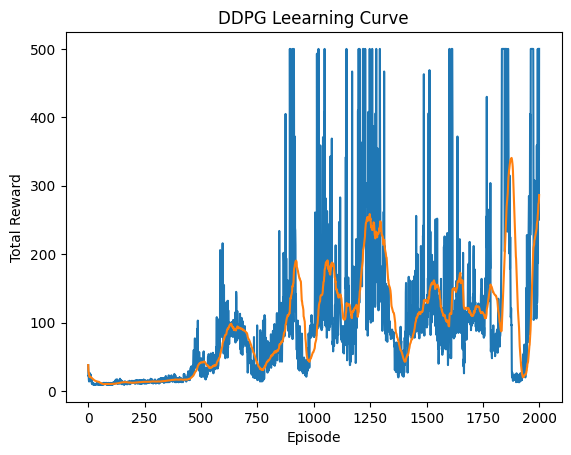

In [43]:
import matplotlib.pyplot as plt
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records)
plt.plot(average_reward)
plt.title("DDPG Leearning Curve")
plt.xlabel("Episode")
plt.ylabel("Total Reward")

## TD3: (Clipped double-Q learning)

In advanced algorithms, such as TD3 (Twin Delayed DDPG), 2 Q-networks - $ Q_{\phi_1}(s, a), Q_{\phi_2}(s, a) $ - and corresponding 2 target networks - $ Q_{\phi_1^{\prime}}(s, a), Q_{\phi_2^{\prime}}(s, a) $ - are used to optimize in order to mitigate the risk of overestimation in Q-function.

In this double-Q algorithms, we optimize parameters as follows :

- Optimize $ \phi_1 $ to minimize $ E\left[ \left( Q_{\phi_1}(s_t, a_t) - \left( r_t + \gamma (1 - d_t) \min_{i=1,2} Q_{{\phi_i}^{\prime}}(s_{t+1},\mu_{\theta^{\prime}}(s_{t+1})) \right) \right)^2 \right] $
- Optimize $ \phi_2 $ to minimize $ E\left[ \left( Q_{\phi_2}(s_t, a_t) - \left( r_t + \gamma (1 - d_t) \min_{i=1,2} Q_{{\phi_i}^{\prime}}(s_{t+1},\mu_{\theta^{\prime}}(s_{t+1})) \right) \right)^2 \right] $
- Optimize $ \theta $ to maximize $Q_{\phi_1}(s, \mu_{\theta}(s))$

And update target parameters as follows :

- $ \phi_1^{\prime} = \tau \phi_1 + (1-\tau) \phi_1^{\prime} $
- $ \phi_2^{\prime} = \tau \phi_2 + (1-\tau) \phi_2^{\prime} $
- $ \theta^{\prime} = \tau \theta + (1-\tau) \theta^{\prime} $

(1) First, regenerate Q-network and policy network as follows.

In [44]:
q_origin_model1 = QNet().to(device)  # Q_phi1
q_origin_model2 = QNet().to(device)  # Q_phi2
q_target_model1 = QNet().to(device)  # Q_phi1'
q_target_model2 = QNet().to(device)  # Q_phi2'
_ = q_target_model1.requires_grad_(False)  # target model doen't need grad
_ = q_target_model2.requires_grad_(False)  # target model doen't need grad

In [45]:
mu_origin_model = PolicyNet().to(device)  # mu_theta
mu_target_model = PolicyNet().to(device)  # mu_theta'
_ = mu_target_model.requires_grad_(False)  # target model doen't need grad

(2) Regenerate optimize function.

In [46]:
gamma = 0.99
opt_q1 = torch.optim.AdamW(q_origin_model1.parameters(), lr=0.0005)
opt_q2 = torch.optim.AdamW(q_origin_model2.parameters(), lr=0.0005)
opt_mu = torch.optim.AdamW(mu_origin_model.parameters(), lr=0.0005)

def optimize(states, actions, rewards, next_states, dones):
    # Convert to tensor
    states = torch.tensor(states, dtype=torch.float).to(device)
    actions = torch.tensor(actions, dtype=torch.float).to(device)
    actions = actions.unsqueeze(dim=1)
    rewards = torch.tensor(rewards, dtype=torch.float).to(device)
    rewards = rewards.unsqueeze(dim=1)
    next_states = torch.tensor(next_states, dtype=torch.float).to(device)
    dones = torch.tensor(dones, dtype=torch.float).to(device)
    dones = dones.unsqueeze(dim=1)

    # Compute r + gamma * (1 - done) * min Q (s_next, mu_target(s_next))
    with torch.no_grad():
        # Get next actions from target policy network
        next_actions = mu_target_model(next_states)
        
        # Add noise to target actions for smoothing (TD3 specific)
        noise = torch.clamp(torch.randn_like(next_actions) * 0.2, -0.5, 0.5)
        smoothed_next_actions = torch.clamp(next_actions + noise, -1.0, 1.0)
        
        # Get Q values from both target Q networks
        next_q1_values = q_target_model1(next_states, smoothed_next_actions)
        next_q2_values = q_target_model2(next_states, smoothed_next_actions)
        
        # Take the minimum of the two Q values (clipped double-Q learning)
        next_q_values = torch.min(next_q1_values, next_q2_values)
        
        # Compute target using Bellman equation
        target_q = rewards + gamma * (1 - dones) * next_q_values

    # Optimize critic loss for Q-network1
    current_q1 = q_origin_model1(states, actions)
    q1_loss = F.mse_loss(current_q1, target_q)
    
    opt_q1.zero_grad()
    q1_loss.backward()
    opt_q1.step()

    # Optimize critic loss for Q-network2
    current_q2 = q_origin_model2(states, actions)
    q2_loss = F.mse_loss(current_q2, target_q)
    
    opt_q2.zero_grad()
    q2_loss.backward()
    opt_q2.step()

    # Optimize actor loss (delayed policy updates - only update every few steps)
    # In TD3, policy updates are typically delayed to occur less frequently than Q-updates
    policy_update_freq = 2  # Update policy every 2 critic updates
    
    if global_step % policy_update_freq == 0:
        # Temporarily disable gradient computation for Q-networks
        for p in q_origin_model1.parameters():
            p.requires_grad = False
        
        # Compute actor loss (negative of Q1 values for actions from current policy)
        policy_actions = mu_origin_model(states)
        actor_loss = -q_origin_model1(states, policy_actions).mean()
        
        # Optimize actor
        opt_mu.zero_grad()
        actor_loss.backward()
        opt_mu.step()
        
        for p in q_origin_model1.parameters():
            p.requires_grad = True  # enable grad again

(3) Regenerate update target's params function.

In [47]:
tau = 0.002

def update_target():
    for var, var_target in zip(q_origin_model1.parameters(), q_target_model1.parameters()):
        var_target.data = tau * var.data + (1.0 - tau) * var_target.data
    for var, var_target in zip(q_origin_model2.parameters(), q_target_model2.parameters()):
        var_target.data = tau * var.data + (1.0 - tau) * var_target.data
    for var, var_target in zip(mu_origin_model.parameters(), mu_target_model.parameters()):
        var_target.data = tau * var.data + (1.0 - tau) * var_target.data

(4) Let's start training again !

In [49]:
# reset noise
ou_action_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(1), sigma=np.ones(1) * 0.05)

# reset buffer
buffer = replayBuffer(buffer_size=50000)

# Define global step counter for delayed policy updates
global_step = 0

# start training
batch_size = 250
reward_records = []
for i in range(2000):
    # Run episode till done
    s = env.reset()
    done = False
    cum_reward = 0
    while not done:
        a = pick_sample(s)
        s_next, r, term, trunc, _ = env.step(a)
        done = term or trunc
        buffer.add([s, a, r, s_next, float(term)])  # (see above note for truncation)
        cum_reward += r

        # Train (optimize parameters)
        if buffer.length() >= batch_size:
            states, actions, rewards, n_states, dones = buffer.sample(batch_size)
            optimize(states, actions, rewards, n_states, dones)
            update_target()
            global_step += 1  # Increment global step for delayed policy updates
        s = s_next

    # Output total rewards in episode (max 500)
    print("Run episode{} with rewards {}".format(i, cum_reward), end="\r")
    reward_records.append(cum_reward)

    # stop if reward mean > 475.0
    if np.average(reward_records[-50:]) > 475.0:
        break

print("\nDone")

Run episode1999 with rewards 500.0
Done


Text(0, 0.5, 'Total Reward')

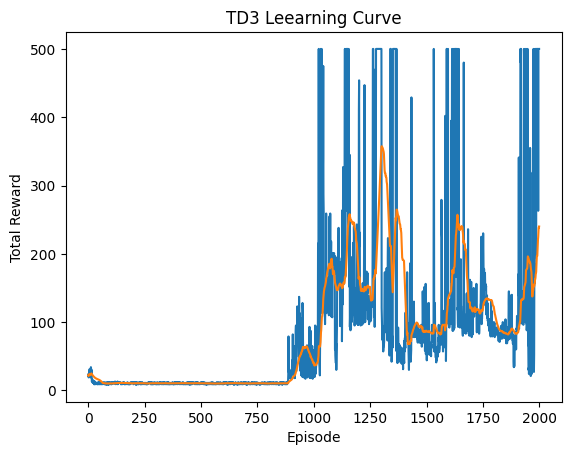

In [50]:
import matplotlib.pyplot as plt
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records)
plt.plot(average_reward)
plt.title("TD3 Leearning Curve")
plt.xlabel("Episode")
plt.ylabel("Total Reward")

## EXTRA CREDIT: SAC (Soft Actor-Critic)

SAC (Soft Actor-Critic) is one of today's popular algorithm, which is based on **off-policy** DDPG. However, unlike DDPG, SAC applies entropy regularization and trains a stochastic policy, not a deterministic policy.

Entropy is defined as $ H(P) = -\int P(x) \log P(x) = E_x[-\log P(x)] $ and it means how $ P(\cdot) $ is distributed intuitively.<br>
For instance, if it has 8 possible states, each of which is equally likely in discrete distribution, it will have $ H(P) = -\sum P(x) \log P(x) = -8 \times \frac{1}{8} \log_2 \frac{1}{8} = 3 $. (This implies that it needs 3 bits evenly.) If the distribution is $ (\frac{1}{2}, \frac{1}{4}, \frac{1}{8}, \frac{1}{16}, \frac{1}{64}, \frac{1}{64}, \frac{1}{64}, \frac{1}{64}) $, it will have $ H(P) = -\frac{1}{2} \log_2 \frac{1}{2} - \frac{1}{4} \log_2 \frac{1}{4} - \frac{1}{8} \log_2 \frac{1}{8} - \frac{1}{16} \log_2 \frac{1}{16} - 4 \times \frac{1}{64} \log_2 \frac{1}{64} = 2 $.<br>
(Note that, for simplicity, I have replaced the base e of logarithm with 2.)<br>

As you can see above, entropy will be larger, when the distribution has much randomness.

In SAC, instead of using a reward expectation $ r_t + \gamma (d_t - 1) Q_{{\phi}^{\prime}} $ used in DDPG, it applies $ r_t + \gamma (d_t - 1) (Q_{{\phi}^{\prime}} + \alpha H(P)) $ (where $\alpha$ is a coefficient parameter for entropy weight, called entropy temperature) in order to balance between exploitation and exploration.<br>
Even if the estimated Q-value increases, it might be rejected when the entropy is largely reduced.

In [51]:
import random
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

In order to prevent from overflows, I apply double precision for float operations.

In [52]:
torch.set_default_dtype(torch.float64)

Unlike DDPG, we can use discrete action space in SAC. (See below for this reason.)<br>
We then now use standard CartPole agent in Gymnasium.

In [53]:
env = gym.make("CartPole-v1")

Unlike DDPG, SAC trains a stochastic policy $ \pi_{\theta}(\cdot) $ (where $ \theta $ is parameters) instead of a deterministic policy $ \mu_{\theta}(\cdot) $. (And we don't use target policy network $ \pi_{\theta^{\prime}} $.)<br>
In this example, I use categorical distribution (same as, used in PG and PPO example) for a policy $ P(\cdot | \pi_\theta(s)) $, because it's discrete action space:

Because we use a stochastic policy, we don't then need Ornstein-Uhlenbeck noise used in DDPG any more.

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Policy net (pi_theta)
class PolicyNet(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()

        self.hidden = nn.Linear(4, hidden_dim)
        self.output = nn.Linear(hidden_dim, 2)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        outs = self.output(outs)
        return outs

pi_model = PolicyNet().to(device)

# Pick up action (for each step in episode)
def pick_sample(s):
    with torch.no_grad():
        #   --> size : (1, 4)
        s_batch = np.expand_dims(s, axis=0)
        s_batch = torch.tensor(s_batch, dtype=torch.float64).to(device)
        # Get logits from state
        #   --> size : (1, 2)
        logits = pi_model(s_batch)
        #   --> size : (2)
        logits = logits.squeeze(dim=0)
        # From logits to probabilities
        probs = F.softmax(logits, dim=-1)
        # Pick up action's sample
        #   --> size : (1)
        a = torch.multinomial(probs, num_samples=1)
        #   --> size : ()
        a = a.squeeze(dim=0)
        # Return
        return a.tolist()

Same as clipped double-Q (twin-Q) DDPG method, we use 2 Q-networks - $ Q_{\phi_1}(s), Q_{\phi_2}(s) $ - and corresponding 2 target networks - $ Q_{\phi_1^{\prime}}(s), Q_{\phi_2^{\prime}}(s) $.

You will find that this is different from the one used in DDPG. (In DDPG, we have used $Q(s, a)$.)<br>
For categorical distribution with the depth n (in this example, n=2), the output of $ Q(\cdot) $ is n-dimensional tensor, in which each element represents the expectation of Q-value for the corresponding action. And we then use $ Q(s) \cdot \tilde{a} $ (i.e, dot product operation) instead of $ Q(s, a) $, where $ \tilde{a} $ is one hot tensor for action $ a $.<br>
Because of this reason, we use $Q(s)$ instead of $Q(s, a)$.

In [55]:
class QNet(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()

        self.hidden = nn.Linear(4, hidden_dim)
        self.output = nn.Linear(hidden_dim, 2)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        outs = self.output(outs)
        return outs

q_origin_model1 = QNet().to(device)  # Q_phi1
q_origin_model2 = QNet().to(device)  # Q_phi2
q_target_model1 = QNet().to(device)  # Q_phi1'
q_target_model2 = QNet().to(device)  # Q_phi2'
_ = q_target_model1.requires_grad_(False)  # target model doen't need grad
_ = q_target_model2.requires_grad_(False)  # target model doen't need grad

As we saw in clipped double-Q DDPG, we optimize policy parameter $ \theta $ to maximize $ Q_{\phi_1}(s, a^*) + \alpha H(P(\cdot | \pi_\theta(s))) $ where $ a^* $ is an optimal action.

As I have mentioned above, $ H(P) = E_x[-\log P(x)] $.<br>
In this categorical distribution (in discrete action space), $ H $ will then be the following dot product :

$ H(P) = H(P(\cdot | \pi_\theta(s))) = -\pi_\theta(s) \cdot \log \pi_\theta(s) $

where $ \pi_\theta(s) $ is one hot probability.

For $ Q(s, a^*) $ term, it will become the following dot product. (See above for this reason.) :

$ Q_{\phi_1}(s, a^*) = Q_{\phi_1}(s) \cdot \pi_\theta(s) $

To summarize, we should optimize $ \theta $ to maximize :

$ E\left[ \pi_\theta(s) \cdot Q_{\phi_1}(s) - \alpha \pi_\theta(s) \cdot \log \pi_\theta(s) \right] = E\left[ \pi_\theta(s) \cdot (Q_{\phi_1}(s) - \alpha \log \pi_\theta(s)) \right] $

In [56]:
alpha = 0.1

opt_pi = torch.optim.AdamW(pi_model.parameters(), lr=0.0005)

class categorical:
    def __init__(self, s):
        logits = pi_model(s)
        self._prob = F.softmax(logits, dim=-1)
        self._logp = torch.log(self._prob)

    # probability (sum is 1.0) : P
    def prob(self):
        return self._prob

    # log probability : log P()
    def logp(self):
        return self._logp

def optimize_theta(states):
    # Convert to tensor
    states = torch.tensor(states, dtype=torch.float64).to(device)
    # Disable grad in q_origin_model1 before computation
    # (or use q_value.detach() not to include in graph)
    for p in q_origin_model1.parameters():
        p.requires_grad = False
    # Optimize
    opt_pi.zero_grad()
    dist = categorical(states)
    q_value = q_origin_model1(states)
    term1 = dist.prob()
    term2 = q_value - alpha * dist.logp()
    expectation = term1.unsqueeze(dim=1) @ term2.unsqueeze(dim=2)
    expectation = expectation.squeeze(dim=1)
    (-expectation).sum().backward()
    opt_pi.step()
    # Enable grad again
    for p in q_origin_model1.parameters():
        p.requires_grad = True

Same as we saw in clipped double-Q DDPG, we optimize parameter $ \phi_1, \phi_2 $ as follows :

- Optimize $ \phi_1 $ to minimize $ E\left[ \left( Q_{\phi_1}(s_t, a_t) - \left( r_t + \gamma (1 - d_t) \left( \min_{i=1,2} Q_{{\phi_i}^{\prime}}(s_{t+1},a^*_{t+1}) + \alpha H(P(\cdot | \pi_\theta(s_{t+1}))) \right) \right) \right)^2 \right] $
- Optimize $ \phi_2 $ to minimize $ E\left[ \left( Q_{\phi_2}(s_t, a_t) - \left( r_t + \gamma (1 - d_t) \left( \min_{i=1,2} Q_{{\phi_i}^{\prime}}(s_{t+1},a^*_{t+1}) + \alpha H(P(\cdot | \pi_\theta(s_{t+1}))) \right) \right) \right)^2 \right] $

in which :

- $ Q_{\phi_i}(s_t, a_t) = Q_{\phi_i}(s_t) \cdot \tilde{a_t} $ where $ \tilde{a_t} $ is one hot vector of $ a_t $
- $ Q_{{\phi_i}^{\prime}}(s_{t+1},a^*_{t+1}) =  Q_{\phi_i^{\prime}}(s_{t+1}) \cdot \pi_\theta(s_{t+1}) $ where $ \pi_\theta(s_{t+1}) $ is one hot probability
- $ H(P(\cdot | \pi_\theta(s_{t+1}))) = -\pi_\theta(s_{t+1}) \cdot \log \pi_\theta(s_{t+1}) $

In [57]:
gamma = 0.99

opt_q1 = torch.optim.AdamW(q_origin_model1.parameters(), lr=0.0005)
opt_q2 = torch.optim.AdamW(q_origin_model2.parameters(), lr=0.0005)

def optimize_phi(states, actions, rewards, next_states, dones):
    #
    # Convert to tensor
    #
    states = torch.tensor(states, dtype=torch.float64).to(device)
    actions = torch.tensor(actions, dtype=torch.int64).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float64).to(device)
    rewards = rewards.unsqueeze(dim=1)
    next_states = torch.tensor(next_states, dtype=torch.float64).to(device)
    dones = torch.tensor(dones, dtype=torch.float64).to(device)
    dones = dones.unsqueeze(dim=1)

    # Compute r + gamma * (1 - d) (min Q(s_next,a_next') + alpha * H(P))
    with torch.no_grad():
        # min Q(s_next,a_next')
        q1_tgt_next = q_target_model1(next_states)
        q2_tgt_next = q_target_model2(next_states)
        dist_next = categorical(next_states)
        q1_target = q1_tgt_next.unsqueeze(dim=1) @ dist_next.prob().unsqueeze(dim=2)
        q1_target = q1_target.squeeze(dim=1)
        q2_target = q2_tgt_next.unsqueeze(dim=1) @ dist_next.prob().unsqueeze(dim=2)
        q2_target = q2_target.squeeze(dim=1)
        q_target_min = torch.minimum(q1_target, q2_target)
        # alpha * H(P)
        h = dist_next.prob().unsqueeze(dim=1) @ dist_next.logp().unsqueeze(dim=2)
        h = h.squeeze(dim=1)
        h = -alpha * h
        # total
        term2 = rewards + gamma * (1.0 - dones) * (q_target_min + h)

    # Optimize critic loss for Q-network1
    q1_pred = q_origin_model1(states)
    # Create one-hot encoding for actions
    actions_one_hot = F.one_hot(actions, num_classes=2).to(torch.float64)
    # Get Q-values for taken actions
    q1_sa = torch.sum(q1_pred * actions_one_hot, dim=1, keepdim=True)
    
    # Compute critic loss for Q-network1
    q1_loss = F.mse_loss(q1_sa, term2)
    
    # Optimize Q-network1
    opt_q1.zero_grad()
    q1_loss.backward()
    opt_q1.step()

    # Optimize critic loss for Q-network2
    q2_pred = q_origin_model2(states)
    # Get Q-values for taken actions
    q2_sa = torch.sum(q2_pred * actions_one_hot, dim=1, keepdim=True)
    
    # Compute critic loss for Q-network2
    q2_loss = F.mse_loss(q2_sa, term2)
    
    # Optimize Q-network2
    opt_q2.zero_grad()
    q2_loss.backward()
    opt_q2.step()


As we saw in TD3, target parameters $\phi_1^{\prime}, \phi_2^{\prime}$ are delayed with coefficient parameter (hyper-parameter) $ \tau $.

In [58]:
tau = 0.002

def update_target():
    for var, var_target in zip(q_origin_model1.parameters(), q_target_model1.parameters()):
        var_target.data = tau * var.data + (1.0 - tau) * var_target.data
    for var, var_target in zip(q_origin_model2.parameters(), q_target_model2.parameters()):
        var_target.data = tau * var.data + (1.0 - tau) * var_target.data

As we saw in DDPG, we use replay buffer to prevent from learning only for recent experiences.

In [59]:
class replayBuffer:
    def __init__(self, buffer_size: int):
        self.buffer_size = buffer_size
        self.buffer = []

    def add(self, item):
        if len(self.buffer) == self.buffer_size:
            self.buffer.pop(0)
        self.buffer.append(item)

    def sample(self, batch_size):
        items = random.sample(self.buffer, batch_size)
        states   = [i[0] for i in items]
        actions  = [i[1] for i in items]
        rewards  = [i[2] for i in items]
        n_states = [i[3] for i in items]
        dones    = [i[4] for i in items]
        return states, actions, rewards, n_states, dones

    def length(self):
        return len(self.buffer)

buffer = replayBuffer(20000)

Now let's put it all together !

In [60]:
batch_size = 250

reward_records = []
for i in range(2000):
    # Run episode till done
    s, _ = env.reset()
    done = False
    cum_reward = 0
    while not done:
        a = pick_sample(s)
        s_next, r, term, trunc, _ = env.step(a)
        done = term or trunc
        buffer.add([s.tolist(), a, r, s_next.tolist(), float(term)])
        cum_reward += r
        if buffer.length() >= batch_size:
            states, actions, rewards, n_states, dones = buffer.sample(batch_size)
            optimize_theta(states)
            optimize_phi(states, actions, rewards, n_states, dones)
            update_target()
        s = s_next

    # Output total rewards in episode (max 500)
    print("Run episode{} with rewards {}".format(i, cum_reward), end="\r")
    reward_records.append(cum_reward)

    # stop if reward mean > 475.0
    if np.average(reward_records[-50:]) > 475.0:
        break

env.close()
print("\nDone")

Run episode759 with rewards 500.0
Done


Text(0, 0.5, 'Total Reward')

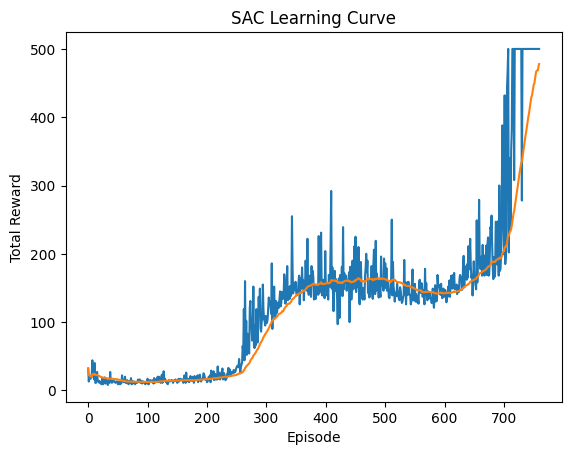

In [61]:
import matplotlib.pyplot as plt
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records)
plt.plot(average_reward)
plt.title("SAC Learning Curve")
plt.xlabel("Episode")
plt.ylabel("Total Reward")

## Extra Credit: PPO (Proximal Policy Optimization)

Proximal Policy Optimization (PPO) is one of successful algorithms in today's reinforcement learning.

PPO is an algorithm that optimizes stochastic policy in on-policy way. However, in order to avoid the loss of performance, PPO algorithm prevents the update from stepping so far.<br>
To prevent large updates in PPO algorithm, there are two variants: PPO-Penalty and PPO-Clip. In this example, we'll focus on PPO-Penalty which is widely used in practical works.

The algorithm will learn policy parameters $ \theta $ with advantages $ A $.<br>
When we assume that the agent takes large advantage $ A $ on action $ a $, $ P(a | \pi_\theta (s)) $ must be increased much more than $ P(a | \pi_{\theta_{old}} (s)) $, with new parameters $ \theta $.<br>
Hence you can expect new $ \theta $ as follows to optimize policy. :

$$ \max_{\theta} E \left[ \frac{P(a | \pi_\theta (s))}{P(a | \pi_{\theta_{old}} (s))} A \right] $$

In order to prevent large policy updates, PPO penaltizes for this expectation as follows :

$$ \max_{\theta} E \left[ \frac{P(a | \pi_\theta (s))}{P(a | \pi_{\theta_{old}} (s))} A - \beta \cdot \verb|penalty| \right] $$

where $ \beta $ is the coefficient for the weight of penalty.

In PPO-Penalty, KL-divergence is used for this penalty term. :

$$ \verb|penalty| := \verb|KL| \left( P(\cdot | \pi_{\theta_{old}} (s)) \| P(\cdot | \pi_\theta (s)) \right) $$

Now I briefly explain about KL-divergence (Kullback-Leibler divergence).<br>
We assume that both $ P(x) $ and $ Q(x) $ are stochastic distributions. KL-divergence $\verb|KL|( P \| Q )$ is then defined as follows and often used in information theory, such as, approximate inference.

$$ \verb|KL|( P \| Q ) := -\int{P(x) \ln{\frac{Q(x)}{P(X)}}}dx $$

By this definition, $ \verb|KL|( P \| Q ) $ will be always positive or zero, and zero if and only if both distributions are same.<br>
This means that $ \verb|KL|( P \| Q ) $ indicates how far between these distributions, $ P $ and $ Q $. If $ Q $ is so far from $ P $, $ \verb|KL|( P \| Q ) $ will become largely positive.

Now go back to our equation. In order to penaltize for large update between $ P(\cdot | \pi_{\theta_{old}} (s)) $ and $ P(\cdot | \pi_\theta (s)) $, we look for the optimal parameters $ \theta $, such as :

$$ \max_{\theta} E \left[ \frac{P(a | \pi_\theta (s))}{P(a | \pi_{\theta_{old}} (s))} A - \beta \cdot \verb|KL| \left( P(\cdot | \pi_{\theta_{old}} (s)) \| P(\cdot | \pi_\theta (s)) \right) \right]  \;\;\;\;\; (1) $$

Even if the first term $ \frac{P(a | \pi_\theta (s))}{P(a | \pi_{\theta_{old}} (s))} A $ largely increases, new $ \theta $ might be rejected when the difference between $ P(\cdot | \pi_{\theta_{old}} (s)) $ and $ P(\cdot | \pi_\theta (s)) $ is so large.

Finally we optimize policy function by maximizing (1), and optimize value function by minimizing value loss.

In [68]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ActorNet(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()

        self.hidden = nn.Linear(4, hidden_dim)
        self.output = nn.Linear(hidden_dim, 2)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        logits = self.output(outs)
        return logits

class ValueNet(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()

        self.hidden = nn.Linear(4, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        value = self.output(outs)
        return value

actor_func = ActorNet().to(device)
value_func = ValueNet().to(device)

As I have mentioned above, we optimize policy function (actor) by maximizing (1), and optimize value function (critic) by minimizing value loss.

Instead of maximizing $ \frac{P(a | \theta_{new})}{P(a | \theta_{old})} A - \beta \cdot \verb|KL| \left( P(\theta_{old}) \| P(\theta_{new}) \right) $ and minimizing value loss $L$, here we simply minimize the following total loss value :

$$ (-1) \frac{P(a | \theta_{new})}{P(a | \theta_{old})} A + \beta \cdot \verb|KL| \left( P(\theta_{old}) \| P(\theta_{new}) \right) + L $$

In this example, both $P$ and $Q$ are discrete (categorical distribution), and KL-divergence is then :

$$ \verb|KL| \left( P(\theta_{old}) \| P(\theta_{new}) \right) = -\sum_a \left( P(a | \theta_{old}) \ln{\frac{P(a | \theta_{new})}{P(a | \theta_{old})}} \right) $$

In [73]:
gamma = 0.99    # discount

# These coefficients are experimentally determined in practice.
kl_coeff = 0.20  # weight coefficient for KL-divergence loss
vf_coeff = 0.50  # weight coefficient for value loss

# Pick up action and following properties for state (s)
# Return :
#     action (int)       action
#     logits (list[int]) logits defining categorical distribution
#     logprb (float)     log probability
def pick_sample_and_logp(s):
    with torch.no_grad():
        #   --> size : (1, 4)
        s_batch = np.expand_dims(s, axis=0)
        s_batch = torch.tensor(s_batch, dtype=torch.float64).to(device)        # Get logits from state
        #   --> size : (1, 2)
        logits = actor_func(s_batch)
        #   --> size : (2)
        logits = logits.squeeze(dim=0)
        # From logits to probabilities
        probs = F.softmax(logits, dim=-1)
        # Pick up action's sample
        #   --> size : (1)
        a = torch.multinomial(probs, num_samples=1)
        #   --> size : ()
        a = a.squeeze(dim=0)
        # Calculate log probability
        logprb = -F.cross_entropy(logits, a, reduction="none")

        # Return
        return a.tolist(), logits.tolist(), logprb.tolist()

env = gym.make("CartPole-v1")
reward_records = []
all_params = list(actor_func.parameters()) + list(value_func.parameters())
opt = torch.optim.AdamW(all_params, lr=0.0005)
for i in range(5000):
    #
    # Run episode till done
    #
    done = False
    states = []
    actions = []
    logits = []
    logprbs = []
    rewards = []
    s, _ = env.reset()
    while not done:
        states.append(s.tolist())
        a, l, p = pick_sample_and_logp(s)
        s, r, term, trunc, _ = env.step(a)
        done = term or trunc
        actions.append(a)
        logits.append(l)
        logprbs.append(p)
        rewards.append(r)

    #
    # Get cumulative rewards
    #
    cum_rewards = np.zeros_like(rewards)
    reward_len = len(rewards)
    for j in reversed(range(reward_len)):
        cum_rewards[j] = rewards[j] + (cum_rewards[j+1]*gamma if j+1 < reward_len else 0)

    #
    # Train (optimize parameters)
    #
    opt.zero_grad()
    # Convert to tensor (all with consistent dtype)
    states = torch.tensor(states, dtype=torch.float64).to(device)
    actions = torch.tensor(actions, dtype=torch.int64).to(device)
    logits_old = torch.tensor(logits, dtype=torch.float64).to(device)
    logprbs = torch.tensor(logprbs, dtype=torch.float64).to(device)
    logprbs = logprbs.unsqueeze(dim=1)
    cum_rewards = torch.tensor(cum_rewards, dtype=torch.float64).to(device)
    cum_rewards = cum_rewards.unsqueeze(dim=1)

    # Get values and logits with new parameters
    values_new = value_func(states)
    logits_new = actor_func(states)    # Get advantages
    advantages = cum_rewards - values_new
    ### # Uncomment if you use normalized advantages (see above note)
    ### advantages = (advantages - advantages.mean()) / advantages.std()
    # Calculate P_new / P_old
    probs_new = F.softmax(logits_new, dim=-1)
    probs_old = F.softmax(logits_old, dim=-1)
    # Get action probabilities
    actions_one_hot = F.one_hot(actions, num_classes=2).to(torch.float)
    prob_new = torch.sum(probs_new * actions_one_hot, dim=1, keepdim=True)
    prob_old = torch.sum(probs_old * actions_one_hot, dim=1, keepdim=True)
    # Calculate ratio
    ratio = prob_new / prob_old

    # Calculate KL-div for Categorical distribution (see above)
    kl_div = torch.sum(probs_old * torch.log(probs_old / probs_new + 1e-10), dim=1, keepdim=True)

    # Get value loss
    value_loss = F.mse_loss(values_new, cum_rewards)

    # Get total loss
    # Policy loss (negative because we want to maximize)
    policy_loss = -torch.mean(ratio * advantages)
    # KL penalty
    kl_loss = torch.mean(kl_div)
    # Combine all losses
    total_loss = policy_loss + kl_coeff * kl_loss + vf_coeff * value_loss

    # Optimize
    total_loss.backward()
    opt.step()

    # Output total rewards in episode (max 500)
    print("Run episode{} with rewards {}".format(i, np.sum(rewards)), end="\r")
    reward_records.append(np.sum(rewards))

    # stop if reward mean > 475.0
    if np.average(reward_records[-50:]) > 475.0:
        break

print("\nDone")
env.close()

Run episode3092 with rewards 500.0
Done


Text(0, 0.5, 'Total Reward')

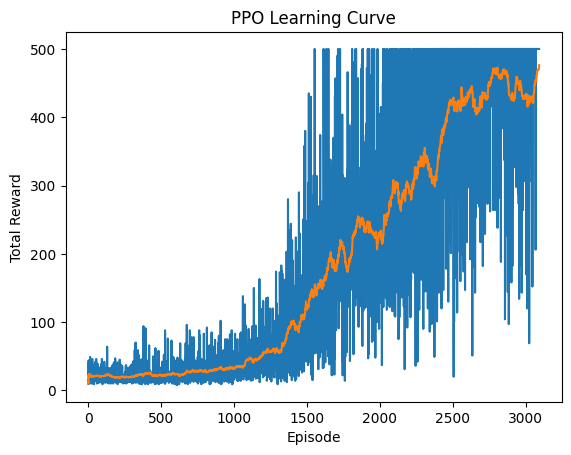

In [75]:
import matplotlib.pyplot as plt
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records)
plt.plot(average_reward)
plt.title("PPO Learning Curve")
plt.xlabel("Episode")
plt.ylabel("Total Reward")